In [1]:
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Masking, GRU, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 


Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("datasets/train.csv")

In [3]:
train_df.head()

,id,filepath,duration,class_label
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water
3,10210062,./assets/audio_train/10210062_flowers.wav,0.399229,flowers
4,10210066,./assets/audio_train/10210066_apples.wav,0.524354,apples


## 3. Preprocessing

There are many ways of preprocessing audio files and the methods of preprocessing is heavily dependent on the type of classification model which will be used.

The model I will be building is:

1. Feedforward Neural Network ( 2 kind of preprocessing )
2. Convolutional Neural Network
3. Recurrent Neural Network with LSTM
4. Ensemble Method

#### Preproccessing for FNN

There are a few ways to process the audio for a simple feedforward neural network. The first and most common way is to find the average of each coefficient of the MFCC across time, which will give us a shape of (40,1) dimensions. 


In [4]:
def get_mfccs_features(file_list, n_mfcc=40):
    """
    This function will take in a list of audio file path and produce 4 times 40 dimensions numpy array (40, 1) which
    will be ready to put into the neural network.
    
    How it works?
    
    For each audio file, it will calculate the Mel-Frequency Cestral Coefficients (MFCCs) over a set
    number of time frames, determined by the sampling rate. The default number of coefficient is set at 40,
    giving us a numpy array of 40 (coefs) by number of timeframes.
    
    In order for it to be have a shape of (, 1), the mean and standard deviation will be calculated, across 
    the entire time frame. As time is also important information which we would not want to lose, the 
    delta of the mfcc will also be calculated, and likewise, the average and the standard deviation will be
    calculated.
    
    mfccs_mean = mean of (40 mfcc x time) - shape = (40,1)
    mfccs_std = standard dev of (40 mfcc x time) - shape = (40,1)
    delta_mean = mean of delta of 40 mfcc across time - shape = (40,1)
    delta_std = standard dev of delta of 40 mfcc across time - shape = (40,1)
    
    
    """
    
    
    features = {}
    mean = []
    std = []
    delta_mean = []
    delta_std = []
    for f in file_list:
        audio, sr = librosa.load(f) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs_delta = librosa.feature.delta(mfccs)
        
        mfccs_mean = np.mean(mfccs.T,axis=0)
        mean.append(mfccs_mean)
        
        mfccs_std = np.std(mfccs.T,axis=0)
        std.append(mfccs_std)
        
        mfccs_delta_mean = np.mean(mfccs_delta.T,axis=0)
        delta_mean.append(mfccs_delta_mean)
        
        mfccs_delta_std = np.std(mfccs_delta.T,axis=0)
        delta_std.append(mfccs_delta_std)
    
    features['mfccs_mean'] = mean
    features['mfccs_std'] = std
    features['mfccs_delta_mean'] = delta_mean
    features['mfccs_delta_std'] = delta_std
    
    return features

In [5]:
# get all the features

mfccs_features = get_mfccs_features(train_df['filepath'])

In [6]:
# add them into the dataframe

for k, v in mfccs_features.items():
    train_df[k] = v

In [7]:
# create a new feature with a dimension of 160, stacking the mean and standard deviation of 
# the mfcc and its delta.

combined_features = []
for n in range(0,len(train_df)):
    combined_features.append(np.concatenate((train_df['mfccs_mean'][n],
                                             train_df['mfccs_std'][n], 
                                             train_df['mfccs_delta_mean'][n],
                                             train_df['mfccs_delta_std'][n])))
    
train_df['combined_mfccs'] = combined_features
# this will give us an array of (160, 1)

In [8]:
# check if all correctly done

train_df.head()

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father,"[-196.65865, 126.91008, -32.876976, 25.416832,...","[58.43318, 37.41045, 29.724075, 16.595234, 13....","[7.6438293, 2.0495448, -2.2808201, 0.26232308,...","[12.530376, 8.677294, 7.3228106, 4.123108, 2.8...","[-196.65865, 126.91008, -32.876976, 25.416832,..."
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker,"[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[62.08626, 30.751865, 25.998608, 21.70042, 16....","[-4.5402517, -3.4924977, -0.37305757, -0.64102...","[10.262612, 6.768381, 4.2443323, 5.0021243, 2....","[-258.90433, 171.56952, 5.8856416, 34.963104, ..."
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water,"[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[87.36377, 34.059155, 39.78111, 24.895144, 33....","[3.2932093, -4.0986385, -3.06783, 1.4283211, 2...","[11.529502, 5.509337, 4.7498536, 5.5789504, 6....","[-235.71283, 148.99991, 7.0049567, 34.56189, -..."
3,10210062,./assets/audio_train/10210062_flowers.wav,0.399229,flowers,"[-233.44008, 127.30211, 11.549065, 42.032394, ...","[44.99465, 60.81429, 18.286491, 29.394094, 21....","[-0.2987371, -4.79065, 2.8436575, 3.4281251, -...","[9.446445, 16.08716, 2.7725258, 6.156691, 4.67...","[-233.44008, 127.30211, 11.549065, 42.032394, ..."
4,10210066,./assets/audio_train/10210066_apples.wav,0.524354,apples,"[-242.86156, 123.218254, -12.731119, 54.86693,...","[71.841354, 71.481544, 38.154087, 27.27552, 38...","[-5.2192245, -10.501004, 5.264592, 1.5651596, ...","[14.663708, 11.573661, 4.3268127, 5.169234, 5....","[-242.86156, 123.218254, -12.731119, 54.86693,..."


**Pre-processing For CNN**

In [9]:
def get_mel(filename):
    """
    This function gives the melspectrogram and padded to a fixed dimension, which is 39. 39 frame happens to be the longest frame.
    The spectrogram can then be used in CNN later.
    """
    
    audio, sr = librosa.load(filename)
    mel= librosa.feature.melspectrogram(audio, sr=sr)
    mel = librosa.util.fix_length(mel,45)
    return mel

In [10]:
# emp = []
# for f in train_df['filepath'].values:
#     audio, sr = librosa.load(f)
#     mel= librosa.feature.melspectrogram(audio, sr=sr)
#     emp.append(mel.shape[1])
    
# max(emp)

In [11]:
# apply the mel-spectrogram function to all the files

train_df['mel'] = train_df['filepath'].map(get_mel)

In [12]:
# check if successful

train_df.head()

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs,mel
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father,"[-196.65865, 126.91008, -32.876976, 25.416832,...","[58.43318, 37.41045, 29.724075, 16.595234, 13....","[7.6438293, 2.0495448, -2.2808201, 0.26232308,...","[12.530376, 8.677294, 7.3228106, 4.123108, 2.8...","[-196.65865, 126.91008, -32.876976, 25.416832,...","[[0.010372462, 0.0030662478, 0.00062838185, 0...."
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker,"[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[62.08626, 30.751865, 25.998608, 21.70042, 16....","[-4.5402517, -3.4924977, -0.37305757, -0.64102...","[10.262612, 6.768381, 4.2443323, 5.0021243, 2....","[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[[0.0010817309, 0.0005368751, 0.001299449, 0.0..."
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water,"[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[87.36377, 34.059155, 39.78111, 24.895144, 33....","[3.2932093, -4.0986385, -3.06783, 1.4283211, 2...","[11.529502, 5.509337, 4.7498536, 5.5789504, 6....","[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[[0.06794148, 0.01626657, 0.0052422658, 0.0144..."
3,10210062,./assets/audio_train/10210062_flowers.wav,0.399229,flowers,"[-233.44008, 127.30211, 11.549065, 42.032394, ...","[44.99465, 60.81429, 18.286491, 29.394094, 21....","[-0.2987371, -4.79065, 2.8436575, 3.4281251, -...","[9.446445, 16.08716, 2.7725258, 6.156691, 4.67...","[-233.44008, 127.30211, 11.549065, 42.032394, ...","[[0.029654736, 0.037957847, 0.040742517, 0.037..."
4,10210066,./assets/audio_train/10210066_apples.wav,0.524354,apples,"[-242.86156, 123.218254, -12.731119, 54.86693,...","[71.841354, 71.481544, 38.154087, 27.27552, 38...","[-5.2192245, -10.501004, 5.264592, 1.5651596, ...","[14.663708, 11.573661, 4.3268127, 5.169234, 5....","[-242.86156, 123.218254, -12.731119, 54.86693,...","[[0.0025025601, 0.0026420446, 0.0025871138, 0...."



## 4. Modelling

Model 1: Vanilla Base-line model

FNN with MFCCS mean
Dimension = 40
layers = 2

In [13]:
X = train_df['mfccs_mean']

In [14]:
X = np.array(X.tolist())

In [15]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(train_df['class_label'].tolist()))
y = np.array(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [17]:
X_test.shape

(210, 40)

In [18]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(40,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 7,109
Trainable params: 7,109
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/50
 - 2s - loss: 5.6487 - accuracy: 0.3063 - val_loss: 3.0937 - val_accuracy: 0.4429
Epoch 2/50
 - 0s - loss: 2.2583 - accuracy: 0.4791 - val_loss: 2.2308 - val_accuracy: 0.5048
Epoch 3/50
 - 0s - loss: 1.6017 - accuracy: 0.5805 - val_loss: 1.6442 - val_accuracy: 0.5714
Epoch 4/50
 - 0s - loss: 1.3061 - accuracy: 0.6138 - val_loss: 1.4876 - val_accuracy: 0.5810
Epoch 5/50
 - 0s - loss: 1.1056 - accuracy: 0.6698 - val_loss: 1.3412 - val_accuracy: 0.6048
Epoch 6/50
 - 0s - loss: 0.9269 - accuracy: 0.6996 - val_loss: 1.1966 - val_accuracy: 0.6286
Epoch 7/50
 - 0s - loss: 0.8513 - accuracy: 0.7008 - val_loss: 1.2221 - val_accuracy: 0.6429
Epoch 8/50
 - 0s - loss: 0.8119 - accuracy: 0.7235 - val_loss: 1.2378 - val_accuracy: 0.6524
Epoch 9/50
 - 0s - loss: 0.7685 - accuracy: 0.7306 - val_loss: 1.1249 - val_accuracy: 0.6714
Epoch 10/50
 - 0s - loss: 0.7055 - accuracy: 0.7592 - val_loss: 1.2564 - val_accuracy: 0.6524
Epoch 11/50
 - 0s - los

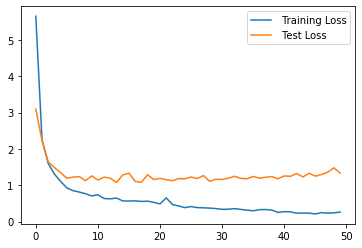

In [22]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

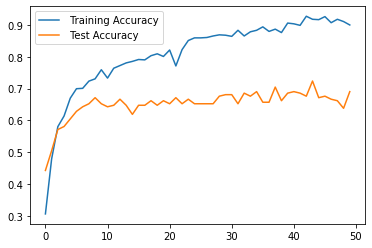

In [23]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [24]:
model_eval = model.evaluate(X_test,y_test, verbose=1)
model_metrics = model.metrics_names

210/210 [==============================] - 0s 38us/step


Model 2

Classifier: FNN
Features: 40 coef * 4 indicators (mean and std, delta mean delta std)
dimension 160


In [25]:
X = np.array(train_df['combined_mfccs'].tolist())

In [26]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [27]:
ss = StandardScaler()
X_train_2 = ss.fit_transform(X_train_2)
X_test_2 = ss.transform(X_test_2)

In [28]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(160,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [29]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [30]:
history = model2.fit(X_train_2, y_train, validation_data=(X_test_2, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/50
 - 0s - loss: 1.4039 - accuracy: 0.4374 - val_loss: 0.9961 - val_accuracy: 0.7095
Epoch 2/50
 - 0s - loss: 0.7238 - accuracy: 0.8153 - val_loss: 0.5239 - val_accuracy: 0.8857
Epoch 3/50
 - 0s - loss: 0.3345 - accuracy: 0.9487 - val_loss: 0.2941 - val_accuracy: 0.9286
Epoch 4/50
 - 0s - loss: 0.1654 - accuracy: 0.9750 - val_loss: 0.2189 - val_accuracy: 0.9381
Epoch 5/50
 - 0s - loss: 0.0944 - accuracy: 0.9857 - val_loss: 0.1933 - val_accuracy: 0.9381
Epoch 6/50
 - 0s - loss: 0.0594 - accuracy: 0.9952 - val_loss: 0.1723 - val_accuracy: 0.9476
Epoch 7/50
 - 0s - loss: 0.0411 - accuracy: 0.9976 - val_loss: 0.1629 - val_accuracy: 0.9476
Epoch 8/50
 - 0s - loss: 0.0280 - accuracy: 0.9988 - val_loss: 0.1539 - val_accuracy: 0.9476
Epoch 9/50
 - 0s - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.9524
Epoch 10/50
 - 0s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.1469 - val_accuracy: 0.9476
Epoch 11/50
 - 0s - los

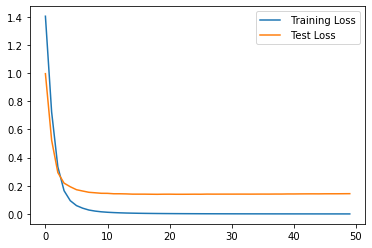

In [31]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

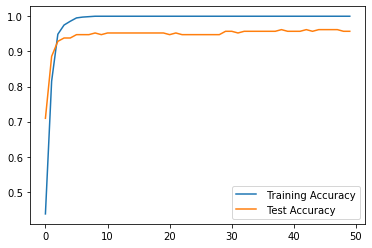

In [32]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [33]:
model2_eval = model2.evaluate(X_test_2,y_test, verbose=1)
model2_metrics = model2.metrics_names

210/210 [==============================] - 0s 38us/step


**CNN**

model 3:

classifier: CNN 2D

Features: mel spectrogram, padded until 45 sequence (128, 39)

In [34]:
X = np.array(train_df['mel'].tolist())

In [35]:
X.shape

(1049, 128, 45)

In [36]:
X.shape

(1049, 128, 45)

In [37]:
X_train_3, X_test_3, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [38]:
X_train_3.shape

(839, 128, 45)

In [39]:
X_train_3 = X_train_3.reshape(X_train_3.shape[0], 128, 45, 1)
X_test_3 = X_test_3.reshape(X_test_3.shape[0], 128, 45, 1)

In [40]:
model3 = Sequential()
model3.add(Conv2D(filters = 6, kernel_size=3, activation = 'relu', input_shape = (128,45,1), padding = 'same'))
model3.add(MaxPooling2D(pool_size= (2,2), padding='same'))
model3.add(Conv2D(32, kernel_size=3, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model3.add(Flatten())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(5, activation = 'softmax'))

In [41]:
model3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [42]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 45, 6)        60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 23, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 21, 32)        1760      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 11, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10912)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                698432    
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [43]:
history = model3.fit(X_train_3,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test_3, y_test),
                        epochs=100,
                        verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 6s - loss: 5.0390 - accuracy: 0.3504 - val_loss: 1.6762 - val_accuracy: 0.5667
Epoch 2/100
 - 0s - loss: 1.1285 - accuracy: 0.6651 - val_loss: 1.1889 - val_accuracy: 0.6571
Epoch 3/100
 - 0s - loss: 0.7434 - accuracy: 0.7616 - val_loss: 0.8845 - val_accuracy: 0.7143
Epoch 4/100
 - 0s - loss: 0.4911 - accuracy: 0.8308 - val_loss: 0.8513 - val_accuracy: 0.7333
Epoch 5/100
 - 0s - loss: 0.3410 - accuracy: 0.8725 - val_loss: 0.7632 - val_accuracy: 0.7905
Epoch 6/100
 - 0s - loss: 0.2052 - accuracy: 0.9273 - val_loss: 0.6863 - val_accuracy: 0.7810
Epoch 7/100
 - 0s - loss: 0.1454 - accuracy: 0.9607 - val_loss: 0.7419 - val_accuracy: 0.7952
Epoch 8/100
 - 0s - loss: 0.1292 - accuracy: 0.9642 - val_loss: 0.9371 - val_accuracy: 0.8143
Epoch 9/100
 - 0s - loss: 0.1071 - accuracy: 0.9690 - val_loss: 0.7391 - val_accuracy: 0.8286
Epoch 10/100
 - 0s - loss: 0.1030 - accuracy: 0.9690 - val_loss: 0.8616 - val_accuracy: 0.8095
Epoch 11/100


Epoch 86/100
 - 0s - loss: 1.8974e-04 - accuracy: 1.0000 - val_loss: 1.1779 - val_accuracy: 0.8619
Epoch 87/100
 - 0s - loss: 1.8427e-04 - accuracy: 1.0000 - val_loss: 1.1802 - val_accuracy: 0.8619
Epoch 88/100
 - 0s - loss: 1.7916e-04 - accuracy: 1.0000 - val_loss: 1.1848 - val_accuracy: 0.8619
Epoch 89/100
 - 0s - loss: 1.7336e-04 - accuracy: 1.0000 - val_loss: 1.1886 - val_accuracy: 0.8619
Epoch 90/100
 - 0s - loss: 1.6903e-04 - accuracy: 1.0000 - val_loss: 1.1918 - val_accuracy: 0.8619
Epoch 91/100
 - 0s - loss: 1.6448e-04 - accuracy: 1.0000 - val_loss: 1.1924 - val_accuracy: 0.8619
Epoch 92/100
 - 0s - loss: 1.5877e-04 - accuracy: 1.0000 - val_loss: 1.1966 - val_accuracy: 0.8619
Epoch 93/100
 - 0s - loss: 1.5416e-04 - accuracy: 1.0000 - val_loss: 1.2034 - val_accuracy: 0.8619
Epoch 94/100
 - 0s - loss: 1.4979e-04 - accuracy: 1.0000 - val_loss: 1.2064 - val_accuracy: 0.8619
Epoch 95/100
 - 0s - loss: 1.4623e-04 - accuracy: 1.0000 - val_loss: 1.2083 - val_accuracy: 0.8619
Epoch 96/1

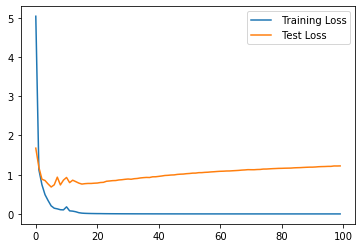

In [44]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

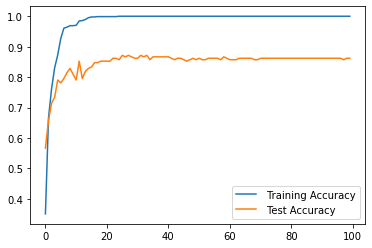

In [45]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [46]:
model3_eval = model3.evaluate(X_test_3,y_test, verbose=1)
model3_metrics = model3.metrics_names

210/210 [==============================] - 0s 71us/step


**CNN**

model 4:

classifier: CNN with picture WIP

In [47]:
# Not yet

**RNN**

Feeding same data as melspectrogram is possible.

In [48]:
X_train_5, X_test_5, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [49]:
model5 = Sequential()

model5.add(LSTM(64, input_shape = (128,45), return_sequences=True))
model5.add(LSTM(64, return_sequences=False ))
model5.add(Dense(64, activation = 'relu'))
model5.add(Dropout(0.3))

model5.add(Dense(5, activation = 'softmax'))

In [50]:
model5.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [51]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           28160     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 65,669
Trainable params: 65,669
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model5.fit(X_train_5,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test_5, y_test),
                        epochs=100,
                        verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 5s - loss: 1.5342 - accuracy: 0.2980 - val_loss: 1.3765 - val_accuracy: 0.3667
Epoch 2/100
 - 4s - loss: 1.3077 - accuracy: 0.3695 - val_loss: 1.2184 - val_accuracy: 0.3952
Epoch 3/100
 - 4s - loss: 1.1745 - accuracy: 0.4482 - val_loss: 1.1920 - val_accuracy: 0.4952
Epoch 4/100
 - 4s - loss: 1.1067 - accuracy: 0.4791 - val_loss: 1.0784 - val_accuracy: 0.5333
Epoch 5/100
 - 4s - loss: 0.9520 - accuracy: 0.5912 - val_loss: 1.0108 - val_accuracy: 0.5619
Epoch 6/100
 - 4s - loss: 0.8503 - accuracy: 0.6365 - val_loss: 1.1076 - val_accuracy: 0.5762
Epoch 7/100
 - 4s - loss: 0.8461 - accuracy: 0.6329 - val_loss: 0.8866 - val_accuracy: 0.6619
Epoch 8/100
 - 4s - loss: 0.7032 - accuracy: 0.7056 - val_loss: 0.8649 - val_accuracy: 0.6762
Epoch 9/100
 - 4s - loss: 0.6824 - accuracy: 0.6985 - val_loss: 0.7131 - val_accuracy: 0.7238
Epoch 10/100
 - 4s - loss: 0.5926 - accuracy: 0.7652 - val_loss: 0.6966 - val_accuracy: 0.7667
Epoch 11/100


Epoch 87/100
 - 4s - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.5511 - val_accuracy: 0.8952
Epoch 88/100
 - 4s - loss: 0.0122 - accuracy: 0.9988 - val_loss: 0.5171 - val_accuracy: 0.9190
Epoch 89/100
 - 4s - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.5669 - val_accuracy: 0.9048
Epoch 90/100
 - 4s - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.5757 - val_accuracy: 0.9000
Epoch 91/100
 - 4s - loss: 0.0057 - accuracy: 0.9976 - val_loss: 0.5745 - val_accuracy: 0.9095
Epoch 92/100
 - 4s - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.5963 - val_accuracy: 0.9000
Epoch 93/100
 - 4s - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.5987 - val_accuracy: 0.9048
Epoch 94/100
 - 4s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6121 - val_accuracy: 0.9000
Epoch 95/100
 - 4s - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.6161 - val_accuracy: 0.9000
Epoch 96/100
 - 4s - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.6317 - val_accuracy: 0.9000
Epoch 97/100
 - 4s - loss: 0.0032 - accuracy: 0.99

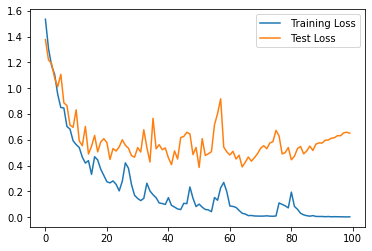

In [53]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

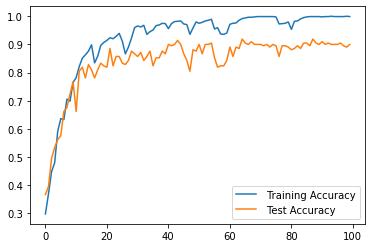

In [54]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [55]:
model5_eval = model5.evaluate(X_test_5,y_test, verbose=1)
model5_metrics = model5.metrics_names

210/210 [==============================] - 0s 972us/step


**Model 6**
mfcc with padding

In [56]:
def get_mfcc(file, n_mfcc=40):
    audio, sr = librosa.load(file) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

In [57]:
mfcc = train_df['filepath'].map(get_mfcc)

In [58]:
X = pad_sequences(mfcc, padding='post')

In [59]:
X.shape

(1049, 42, 40)

In [60]:
X_train_6, X_test_6, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [61]:
model6 = Sequential()

model6.add(Masking(mask_value=0, input_shape=(42, 40)))
model6.add(LSTM(64, input_shape = (42,40), return_sequences=True))
model6.add(LSTM(64, return_sequences=False ))
model6.add(Dense(64, activation = 'relu'))
model6.add(Dropout(0.3))

model6.add(Dense(5, activation = 'softmax'))

In [62]:
model6.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [63]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 42, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 42, 64)            26880     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
__________________________________________________

In [64]:
history = model6.fit(X_train_6,
                    y_train,
                    batch_size=32,
                    validation_data=(X_test_6, y_test),
                    epochs=100,
                    verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 3s - loss: 1.4775 - accuracy: 0.3588 - val_loss: 1.2478 - val_accuracy: 0.5619
Epoch 2/100
 - 2s - loss: 0.9696 - accuracy: 0.6567 - val_loss: 0.6536 - val_accuracy: 0.8000
Epoch 3/100
 - 2s - loss: 0.4333 - accuracy: 0.8772 - val_loss: 0.3036 - val_accuracy: 0.8905
Epoch 4/100
 - 2s - loss: 0.2302 - accuracy: 0.9416 - val_loss: 0.2299 - val_accuracy: 0.9190
Epoch 5/100
 - 2s - loss: 0.1404 - accuracy: 0.9619 - val_loss: 0.1969 - val_accuracy: 0.9238
Epoch 6/100
 - 2s - loss: 0.0787 - accuracy: 0.9809 - val_loss: 0.1722 - val_accuracy: 0.9524
Epoch 7/100
 - 2s - loss: 0.0635 - accuracy: 0.9833 - val_loss: 0.1595 - val_accuracy: 0.9476
Epoch 8/100
 - 2s - loss: 0.0821 - accuracy: 0.9738 - val_loss: 0.1926 - val_accuracy: 0.9476
Epoch 9/100
 - 2s - loss: 0.0634 - accuracy: 0.9797 - val_loss: 0.1982 - val_accuracy: 0.9238
Epoch 10/100
 - 2s - loss: 0.0444 - accuracy: 0.9905 - val_loss: 0.1575 - val_accuracy: 0.9524
Epoch 11/100


Epoch 85/100
 - 2s - loss: 4.5341e-04 - accuracy: 1.0000 - val_loss: 0.2705 - val_accuracy: 0.9667
Epoch 86/100
 - 2s - loss: 7.1146e-05 - accuracy: 1.0000 - val_loss: 0.2607 - val_accuracy: 0.9667
Epoch 87/100
 - 2s - loss: 7.4030e-05 - accuracy: 1.0000 - val_loss: 0.2596 - val_accuracy: 0.9667
Epoch 88/100
 - 2s - loss: 4.5828e-05 - accuracy: 1.0000 - val_loss: 0.2646 - val_accuracy: 0.9667
Epoch 89/100
 - 2s - loss: 6.3899e-05 - accuracy: 1.0000 - val_loss: 0.2648 - val_accuracy: 0.9667
Epoch 90/100
 - 2s - loss: 1.2101e-04 - accuracy: 1.0000 - val_loss: 0.2625 - val_accuracy: 0.9714
Epoch 91/100
 - 2s - loss: 1.3026e-04 - accuracy: 1.0000 - val_loss: 0.2628 - val_accuracy: 0.9714
Epoch 92/100
 - 2s - loss: 6.2587e-05 - accuracy: 1.0000 - val_loss: 0.2702 - val_accuracy: 0.9667
Epoch 93/100
 - 2s - loss: 6.5249e-05 - accuracy: 1.0000 - val_loss: 0.2709 - val_accuracy: 0.9667
Epoch 94/100
 - 2s - loss: 1.2159e-04 - accuracy: 1.0000 - val_loss: 0.2683 - val_accuracy: 0.9667
Epoch 95/1

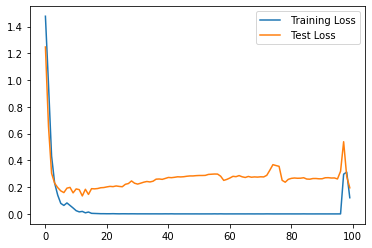

In [65]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

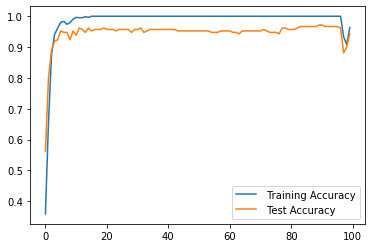

In [66]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [67]:
model6_eval = model6.evaluate(X_test_6,y_test, verbose=1)
model6_metrics = model6.metrics_names

210/210 [==============================] - 0s 610us/step


Model 7 
RNN with GRU

In [68]:
X_train_7, X_test_7, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [69]:
model7 = Sequential()

model7.add(Masking(mask_value=0, input_shape=(42, 40)))
model7.add(GRU(64, input_shape = (42,40), return_sequences=True))
model7.add(GRU(64, return_sequences=False ))
model7.add(Dense(64, activation = 'relu'))
model7.add(Dropout(0.3))

model7.add(Dense(5, activation = 'softmax'))

In [70]:
model7.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [71]:
model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 42, 40)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 42, 64)            20160     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
Total params: 49,413
Trainable params: 49,413
Non-trainable params: 0
__________________________________________________

In [72]:
history = model7.fit(X_train_7,
                    y_train,
                    batch_size=32,
                    validation_data=(X_test_7, y_test),
                    epochs=100,
                    verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 3s - loss: 1.4137 - accuracy: 0.4005 - val_loss: 1.0656 - val_accuracy: 0.6524
Epoch 2/100
 - 2s - loss: 0.8865 - accuracy: 0.6925 - val_loss: 0.6073 - val_accuracy: 0.8095
Epoch 3/100
 - 2s - loss: 0.4957 - accuracy: 0.8534 - val_loss: 0.3372 - val_accuracy: 0.8762
Epoch 4/100
 - 2s - loss: 0.2624 - accuracy: 0.9249 - val_loss: 0.2348 - val_accuracy: 0.9143
Epoch 5/100
 - 2s - loss: 0.1696 - accuracy: 0.9452 - val_loss: 0.2705 - val_accuracy: 0.8905
Epoch 6/100
 - 2s - loss: 0.1074 - accuracy: 0.9690 - val_loss: 0.2159 - val_accuracy: 0.9238
Epoch 7/100
 - 2s - loss: 0.0879 - accuracy: 0.9774 - val_loss: 0.2793 - val_accuracy: 0.8905
Epoch 8/100
 - 2s - loss: 0.0658 - accuracy: 0.9821 - val_loss: 0.2088 - val_accuracy: 0.9333
Epoch 9/100
 - 2s - loss: 0.0487 - accuracy: 0.9893 - val_loss: 0.3335 - val_accuracy: 0.9048
Epoch 10/100
 - 2s - loss: 0.0314 - accuracy: 0.9928 - val_loss: 0.1777 - val_accuracy: 0.9476
Epoch 11/100


Epoch 85/100
 - 2s - loss: 1.6425e-04 - accuracy: 1.0000 - val_loss: 0.1858 - val_accuracy: 0.9476
Epoch 86/100
 - 2s - loss: 2.2441e-04 - accuracy: 1.0000 - val_loss: 0.1870 - val_accuracy: 0.9476
Epoch 87/100
 - 2s - loss: 2.1282e-04 - accuracy: 1.0000 - val_loss: 0.1956 - val_accuracy: 0.9429
Epoch 88/100
 - 2s - loss: 2.0572e-04 - accuracy: 1.0000 - val_loss: 0.1972 - val_accuracy: 0.9429
Epoch 89/100
 - 2s - loss: 1.3286e-04 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9429
Epoch 90/100
 - 2s - loss: 2.9352e-04 - accuracy: 1.0000 - val_loss: 0.1921 - val_accuracy: 0.9524
Epoch 91/100
 - 2s - loss: 1.0571e-04 - accuracy: 1.0000 - val_loss: 0.1924 - val_accuracy: 0.9429
Epoch 92/100
 - 2s - loss: 1.1888e-04 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.9476
Epoch 93/100
 - 2s - loss: 2.4047e-04 - accuracy: 1.0000 - val_loss: 0.1901 - val_accuracy: 0.9476
Epoch 94/100
 - 2s - loss: 9.1349e-05 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 0.9476
Epoch 95/1

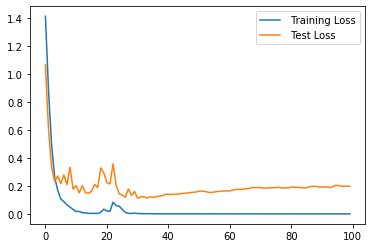

In [73]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

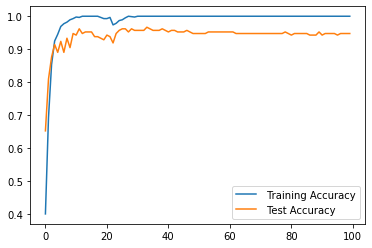

In [74]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [75]:
model7_eval = model7.evaluate(X_test_7, y_test, verbose=1)
model7_metrics = model7.metrics_names

210/210 [==============================] - 0s 548us/step


## Evaluation


In [76]:
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
print(f"Model 1 {model_metrics[0]}: {model_eval[0]}")
print(f"Model 1 {model_metrics[1]}: {model_eval[1]}\n")

print(f"Model 2 {model2_metrics[0]}: {model2_eval[0]}")
print(f"Model 2 {model2_metrics[1]}: {model2_eval[1]}\n")

print(f"Model 3 {model3_metrics[0]}: {model3_eval[0]}")
print(f"Model 3 {model3_metrics[1]}: {model3_eval[1]}\n")

print(f"Model 5 {model5_metrics[0]}: {model5_eval[0]}")
print(f"Model 5 {model5_metrics[1]}: {model5_eval[1]}\n")

print(f"Model 6 {model6_metrics[0]}: {model6_eval[0]}")
print(f"Model 6 {model6_metrics[1]}: {model6_eval[1]}\n")

print(f"Model 7 {model7_metrics[0]}: {model7_eval[0]}")
print(f"Model 7 {model7_metrics[1]}: {model7_eval[1]}\n")


Model 1 loss: 1.3340803691319056
Model 1 accuracy: 0.6904761791229248

Model 2 loss: 0.14409425719862892
Model 2 accuracy: 0.9571428298950195

Model 3 loss: 1.223705840678442
Model 3 accuracy: 0.8619047403335571

Model 5 loss: 0.6506791736398424
Model 5 accuracy: 0.8999999761581421

Model 6 loss: 0.19505064671947842
Model 6 accuracy: 0.9428571462631226

Model 7 loss: 0.19745460754022046
Model 7 accuracy: 0.9476190209388733



Get Predictions for Each Model

In [78]:
labels = list(le.classes_)

y_test_labels = []
for pred in y_test:
    for n, i in enumerate(pred):
        if i == 1:
            y_test_labels.append(labels[n])
            
y_test_labels

['flowers',
 'water',
 'apples',
 'flowers',
 'flowers',
 'worker',
 'apples',
 'father',
 'worker',
 'worker',
 'flowers',
 'father',
 'worker',
 'father',
 'apples',
 'water',
 'flowers',
 'flowers',
 'flowers',
 'flowers',
 'father',
 'worker',
 'worker',
 'water',
 'flowers',
 'father',
 'father',
 'father',
 'flowers',
 'worker',
 'father',
 'worker',
 'father',
 'worker',
 'apples',
 'father',
 'worker',
 'worker',
 'worker',
 'apples',
 'flowers',
 'flowers',
 'water',
 'worker',
 'flowers',
 'father',
 'father',
 'father',
 'worker',
 'father',
 'water',
 'water',
 'flowers',
 'apples',
 'water',
 'water',
 'water',
 'water',
 'father',
 'flowers',
 'worker',
 'worker',
 'worker',
 'worker',
 'water',
 'flowers',
 'worker',
 'apples',
 'apples',
 'worker',
 'apples',
 'flowers',
 'father',
 'worker',
 'apples',
 'apples',
 'flowers',
 'water',
 'water',
 'apples',
 'father',
 'apples',
 'apples',
 'father',
 'water',
 'water',
 'apples',
 'father',
 'apples',
 'worker',
 'fathe

In [79]:
y_pred = model.predict_classes(X_test)
y_pred = list(le.inverse_transform(y_pred))

print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

      apples       0.64      0.69      0.67        42
      father       0.65      0.71      0.68        42
     flowers       0.62      0.57      0.59        42
       water       0.72      0.86      0.78        42
      worker       0.87      0.62      0.72        42

    accuracy                           0.69       210
   macro avg       0.70      0.69      0.69       210
weighted avg       0.70      0.69      0.69       210



In [80]:
y_pred2 = model2.predict_classes(X_test_2)
y_pred2 = list(le.inverse_transform(y_pred2))

print(classification_report(y_test_labels, y_pred2))

              precision    recall  f1-score   support

      apples       0.95      0.98      0.96        42
      father       0.98      0.98      0.98        42
     flowers       0.95      0.93      0.94        42
       water       0.95      0.93      0.94        42
      worker       0.95      0.98      0.96        42

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



In [81]:
y_pred3 = model3.predict_classes(X_test_3)
y_pred3 = list(le.inverse_transform(y_pred3))

print(classification_report(y_test_labels, y_pred3))

              precision    recall  f1-score   support

      apples       0.93      0.93      0.93        42
      father       0.84      0.74      0.78        42
     flowers       0.84      0.88      0.86        42
       water       0.77      0.86      0.81        42
      worker       0.95      0.90      0.93        42

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210



In [82]:
y_pred5 = model5.predict_classes(X_test_5)
y_pred5 = list(le.inverse_transform(y_pred5))

print(classification_report(y_test_labels, y_pred5))

              precision    recall  f1-score   support

      apples       0.97      0.93      0.95        42
      father       0.79      0.88      0.83        42
     flowers       0.93      0.95      0.94        42
       water       0.90      0.83      0.86        42
      worker       0.93      0.90      0.92        42

    accuracy                           0.90       210
   macro avg       0.90      0.90      0.90       210
weighted avg       0.90      0.90      0.90       210



In [83]:
y_pred6 = model6.predict_classes(X_test_6)
y_pred6 = list(le.inverse_transform(y_pred6))

print(classification_report(y_test_labels, y_pred6))

              precision    recall  f1-score   support

      apples       0.93      0.93      0.93        42
      father       0.98      0.95      0.96        42
     flowers       1.00      0.93      0.96        42
       water       0.87      0.98      0.92        42
      worker       0.95      0.93      0.94        42

    accuracy                           0.94       210
   macro avg       0.95      0.94      0.94       210
weighted avg       0.95      0.94      0.94       210



In [84]:
y_pred7 = model7.predict_classes(X_test_7)
y_pred7 = list(le.inverse_transform(y_pred7))

print(classification_report(y_test_labels, y_pred7))

              precision    recall  f1-score   support

      apples       0.95      0.95      0.95        42
      father       1.00      0.93      0.96        42
     flowers       0.98      0.95      0.96        42
       water       0.91      0.98      0.94        42
      worker       0.91      0.93      0.92        42

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



The top 2 performing models are Model 2 and Model 7, based on the accuracy and the f1 score.

**Unseen Data**

In [85]:
# import test data
test_df = pd.read_csv("./datasets/test.csv")
test_df.head()

,id,filepath,duration,class_label
0,8750049,./assets/audio_test/8750049_father.wav,0.353016,father
1,8750049,./assets/audio_test/8750049_worker.wav,0.531655,worker
2,8750051,./assets/audio_test/8750051_water.wav,0.374467,water
3,8750062,./assets/audio_test/8750062_flowers.wav,0.533379,flowers
4,8750066,./assets/audio_test/8750066_apples.wav,0.503719,apples


In [86]:
# preprocess the same as previously
test_mfccs_features = get_mfccs_features(test_df['filepath'])


In [87]:
# add them into the dataframe

for k, v in test_mfccs_features.items():
    test_df[k] = v

In [88]:
# create a new feature with a dimension of 160, stacking the mean and standard deviation of 
# the mfcc and its delta.

combined_features = []
for n in range(0,len(test_df)):
    combined_features.append(np.concatenate((test_df['mfccs_mean'][n],
                                             test_df['mfccs_std'][n], 
                                             test_df['mfccs_delta_mean'][n],
                                             test_df['mfccs_delta_std'][n])))
    
test_df['combined_mfccs'] = combined_features
# this will give us an array of (160, 1)

In [89]:
test_df

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs
0,8750049,./assets/audio_test/8750049_father.wav,0.353016,father,"[-169.13393, 136.69135, -31.809338, 20.55186, ...","[41.70879, 21.830057, 27.636902, 12.362332, 18...","[1.9910371, -0.25411266, -2.515326, 1.3795561,...","[8.519464, 4.3707027, 4.3258567, 1.7772573, 2....","[-169.13393, 136.69135, -31.809338, 20.55186, ..."
1,8750049,./assets/audio_test/8750049_worker.wav,0.531655,worker,"[-287.14914, 180.64957, 22.688225, -9.836566, ...","[74.63576, 30.15931, 21.801395, 15.327445, 15....","[-5.404343, -2.924971, 1.0068195, -0.86250436,...","[19.696611, 6.326892, 5.3654685, 3.914428, 4.0...","[-287.14914, 180.64957, 22.688225, -9.836566, ..."
2,8750051,./assets/audio_test/8750051_water.wav,0.374467,water,"[-221.17166, 137.10963, 11.459793, 28.60778, -...","[66.85327, 36.957886, 32.5245, 16.585081, 24.3...","[-2.8528218, -7.177959, -1.6909441, 0.9749463,...","[9.90385, 2.6404707, 5.663468, 1.8970118, 5.49...","[-221.17166, 137.10963, 11.459793, 28.60778, -..."
3,8750062,./assets/audio_test/8750062_flowers.wav,0.533379,flowers,"[-219.64317, 124.65655, -11.501224, 17.839247,...","[50.044624, 25.74483, 34.892227, 18.774397, 29...","[-4.74574, -2.835228, 2.4696124, 0.986755, 1.1...","[10.575305, 3.459822, 8.680221, 4.149211, 7.07...","[-219.64317, 124.65655, -11.501224, 17.839247,..."
4,8750066,./assets/audio_test/8750066_apples.wav,0.503719,apples,"[-248.58002, 125.00463, -3.9754348, 30.73246, ...","[88.9623, 53.28954, 24.958252, 22.293911, 21.7...","[-10.459837, -8.300082, 4.2740784, -1.519041, ...","[21.781862, 8.261361, 5.409559, 5.4887886, 4.5...","[-248.58002, 125.00463, -3.9754348, 30.73246, ..."
...,...,...,...,...,...,...,...,...,...
96,9870049,./assets/audio_test/9870049_father.wav,0.587982,father,"[-196.22722, 102.0927, -74.91568, -2.595125, -...","[65.40566, 34.256218, 36.006527, 13.360244, 15...","[5.9519963, 4.050389, -2.873619, -1.5295701, -...","[16.287975, 3.9399867, 9.447657, 2.9682708, 3....","[-196.22722, 102.0927, -74.91568, -2.595125, -..."
97,9870049,./assets/audio_test/9870049_worker.wav,0.568163,worker,"[-248.18979, 141.14734, -41.28263, -17.265291,...","[89.608635, 19.2947, 35.326454, 19.52412, 28.1...","[-11.376947, -0.6605424, 2.421873, -0.9720291,...","[21.338057, 3.4204795, 6.741491, 5.65387, 5.96...","[-248.18979, 141.14734, -41.28263, -17.265291,..."
98,9870051,./assets/audio_test/9870051_water.wav,0.536281,water,"[-303.37057, 115.21334, -10.535064, 11.90516, ...","[113.12243, 36.79969, 51.238903, 20.566242, 37...","[-1.3606787, -1.0921255, -1.0485204, 0.7690955...","[32.91524, 7.514545, 15.058225, 3.5036483, 10....","[-303.37057, 115.21334, -10.535064, 11.90516, ..."
99,9870062,./assets/audio_test/9870062_flowers.wav,0.616780,flowers,"[-226.4825, 75.7703, -46.44616, 18.340668, -64...","[55.853706, 48.912666, 39.156635, 17.689342, 1...","[-4.853439, -3.8178694, 2.1544454, -0.15217713...","[12.745464, 10.484804, 8.294652, 4.581363, 5.1...","[-226.4825, 75.7703, -46.44616, 18.340668, -64..."


In [90]:
X = np.array(test_df['combined_mfccs'].tolist())

In [91]:
model2.predict_classes(X)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [92]:
def get_mfcc(file, n_mfcc=40):
    audio, sr = librosa.load(file) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

In [93]:
mfcc_test = test_df['filepath'].map(get_mfcc)

In [94]:
X = pad_sequences(mfcc_test, padding='post', maxlen=42)

In [95]:
X.shape

(101, 42, 40)

In [96]:
y_test_pred = model7.predict_classes(X)

In [97]:
y_test_pred = list(le.inverse_transform(y_test_pred))

In [98]:
print(classification_report(test_df['class_label'], y_test_pred))

              precision    recall  f1-score   support

      apples       0.91      1.00      0.95        20
      father       0.95      1.00      0.98        20
     flowers       1.00      0.86      0.92        21
       water       1.00      1.00      1.00        20
      worker       1.00      1.00      1.00        20

    accuracy                           0.97       101
   macro avg       0.97      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101



Father classified as flowers

In [99]:
y_test_pred = model6.predict_classes(X)
y_test_pred = list(le.inverse_transform(y_test_pred))
print(classification_report(test_df['class_label'], y_test_pred))

              precision    recall  f1-score   support

      apples       0.95      1.00      0.98        20
      father       0.95      1.00      0.98        20
     flowers       1.00      0.90      0.95        21
       water       0.95      1.00      0.98        20
      worker       0.95      0.90      0.92        20

    accuracy                           0.96       101
   macro avg       0.96      0.96      0.96       101
weighted avg       0.96      0.96      0.96       101

